# Modelo de Prophet para la Serie de Ivan

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import datetime
import random
from prophet import Prophet

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
from scipy import stats
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource


from pylab import rcParams
rcParams['figure.figsize'] = (18,7)


Importing plotly failed. Interactive plots will not work.


In [2]:
ruta=r"C:\Users\jlopez_rapicredit\Documents\series\Serie_Ivan.xlsx"
ivan=pd.read_excel(ruta, usecols=["DATE","KMS","TIME"])
ivan.tail(8)

,DATE,KMS,TIME
260,2023-12-25,126.2,543
261,2024-01-01,206.3,839
262,2024-01-08,211.0,873
263,2024-01-15,202.2,867
264,2024-01-22,200.9,864
265,2024-01-29,160.7,680
266,2024-02-05,135.7,562
267,2024-02-12,121.8,494


In [3]:
ivan.dtypes

DATE    datetime64[ns]
KMS            float64
TIME             int64
dtype: object

#### Gráficos descriptivos de ayuda

**Variable Kms**

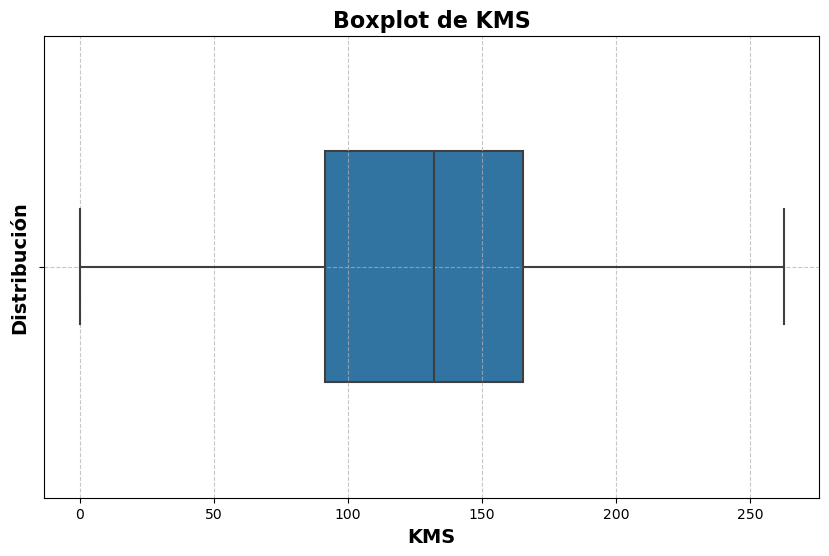

In [4]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=ivan, x='KMS', width=0.5, fliersize=8, linewidth=1.5)

# Personalizar el boxplot
ax.set_xlabel('KMS', fontsize=14, weight='bold')
ax.set_ylabel('Distribución', fontsize=14, weight='bold')
ax.set_title('Boxplot de KMS', fontsize=16, weight='bold')
ax.grid(True, linestyle='--', alpha=0.7)

# Añadir etiquetas a los valores atípicos (opcional)
for flier in ax.artists:
    flier.set_edgecolor('black')
    flier.set_linewidth(1)

plt.show()

**Variable Time**

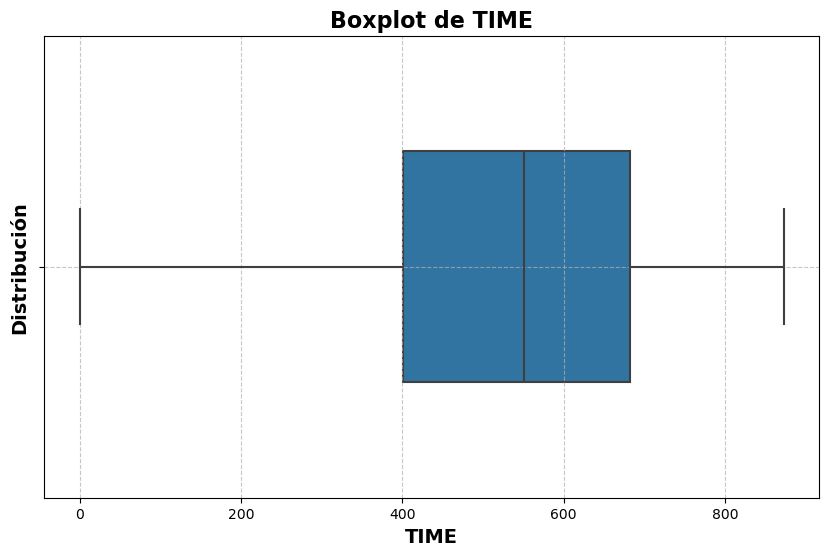

In [5]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=ivan, x='TIME', width=0.5, fliersize=8, linewidth=1.5)

# Personalizar el boxplot
ax.set_xlabel('TIME', fontsize=14, weight='bold')
ax.set_ylabel('Distribución', fontsize=14, weight='bold')
ax.set_title('Boxplot de TIME', fontsize=16, weight='bold')
ax.grid(True, linestyle='--', alpha=0.7)

# Añadir etiquetas a los valores atípicos (opcional)
for flier in ax.artists:
    flier.set_edgecolor('black')
    flier.set_linewidth(1)

plt.show()

**Correlación entre Kms y Time**

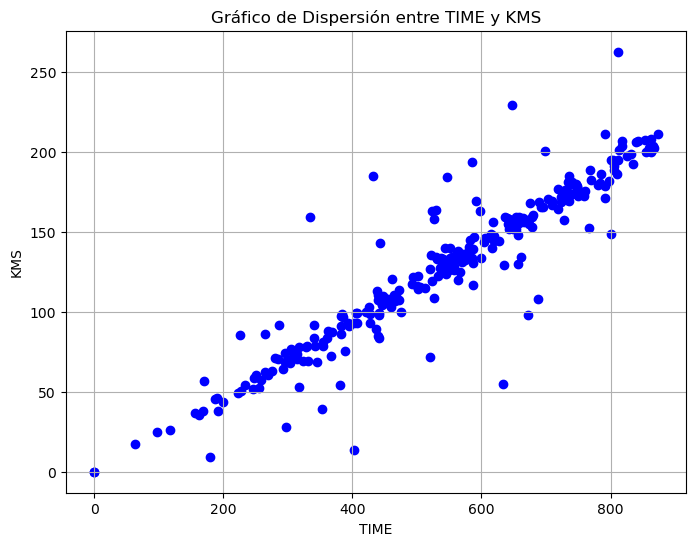

In [6]:
plt.figure(figsize=(8, 6))
plt.scatter(ivan['TIME'], ivan['KMS'], color='blue', marker='o')

# Añadir etiquetas y título
plt.xlabel('TIME')
plt.ylabel('KMS')
plt.title('Gráfico de Dispersión entre TIME y KMS')

# Mostrar el gráfico
plt.grid(True)
plt.show()

In [7]:
import numpy as np
correlation_coefficient = np.corrcoef(ivan['TIME'], ivan['KMS'])[0, 1]
correlation_coefficient

0.932390763875699

#### Renombrando columnas

In [8]:
#cambiamos los nombres de las columnas dado que el paquete lo solicita
npivan=ivan.copy()
npivan=npivan.rename(columns={"DATE":"ds","KMS":"y","TIME":"time"})
npivan

,ds,y,time
0,2018-12-31,17.3,64
1,2019-01-07,86.4,265
2,2019-01-14,107.3,472
3,2019-01-21,163.1,597
4,2019-01-28,153.5,648
...,...,...,...
263,2024-01-15,202.2,867
264,2024-01-22,200.9,864
265,2024-01-29,160.7,680
266,2024-02-05,135.7,562


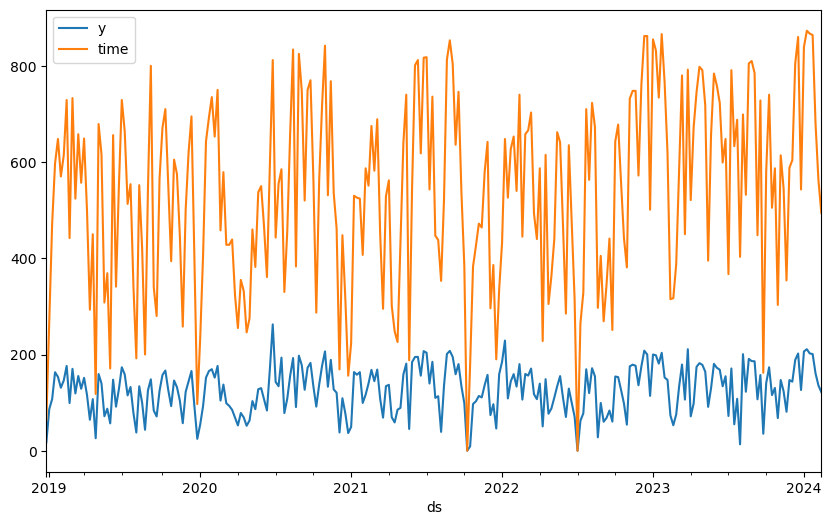

In [9]:
fig = npivan.plot(x="ds", y=["y", "time"], figsize=(10, 6))

In [10]:
train=npivan.loc[npivan['ds'] <= '2023-12-25']
test=npivan[npivan['ds'] > '2023-12-25']

test.drop("y", axis=1, inplace=True)
train.shape, test.shape

((261, 3), (7, 2))

### Importando el modelo Prophet

In [11]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from mlforecast.target_transforms import LocalRobustScaler, LocalStandardScaler
%matplotlib inline
import matplotlib.pyplot as plt

#### Definición del modelo con valores por defecto y validación cruzada

La función `cross_validation` de la biblioteca Prophet se utiliza para evaluar el rendimiento de un modelo de pronóstico en series temporales mediante validación cruzada temporal. A continuación se describen los aspectos clave de esta función:

##### Parámetros

- **`model`**: El modelo Prophet que ha sido previamente ajustado.
- **`horizon`**: Duración del período de pronóstico, especificada en un formato compatible con `pd.Timedelta`, como `'5 days'` o `'3 hours'`.
- **`period`**: Frecuencia con la que se realizarán los pronósticos. Se especifica en un formato compatible con `pd.Timedelta`. Si no se proporciona, se usa por defecto la mitad del `horizon`.
- **`initial`**: Período mínimo de datos de entrenamiento antes de hacer la primera predicción. Se especifica en un formato compatible con `pd.Timedelta`. Si no se proporciona, se usa por defecto tres veces el `horizon`.
- **`cutoffs`**: Lista de puntos de corte que se usarán para hacer los pronósticos. Si no se proporcionan, se generan automáticamente.
- **`parallel`**: Método para paralelizar el cálculo de los pronósticos. Puede ser `None`, `'processes'`, `'threads'`, `'dask'`, o un objeto con un método `.map`.
- **`disable_tqdm`**: Si es `True`, desactiva la barra de progreso.
- **`extra_output_columns`**: Columnas adicionales que se incluyen en el resultado, como `'trend'`.

##### Proceso de Validación Cruzada

- **Generación de Cortes de Tiempo**: La función utiliza puntos de corte para realizar pronósticos. Si no se proporcionan, se generan automáticamente comenzando desde el final del conjunto de datos y trabajando hacia atrás.
- **Entrenamiento y Prueba**: Para cada punto de corte, el modelo se entrena con los datos hasta ese punto de corte menos el horizonte de predicción. Luego, se realiza una predicción para el horizonte definido después del punto de corte.
- **Horizonte**: Define el período para el cual se realiza la predicción, como `'10 days'`.
- **Espaciado del Período**: Define la frecuencia de los puntos de corte. Por ejemplo, `'5 days'` genera puntos de corte cada 5 días.
- **Tamaño Inicial**: Especifica la cantidad mínima de datos de entrenamiento antes de hacer el primer pronóstico, por ejemplo `'30 days'`.

##### Resultados

El resultado de la función es un `DataFrame` que incluye:
- **`ds`**: Fechas para las cuales se hicieron las predicciones.
- **`yhat`**: Predicciones realizadas por el modelo.
- **`y`**: Valores reales observados.
- **`cutoff`**: Puntos de corte utilizados para cada pronóstico.


In [12]:
m1 = Prophet()
m1.fit(npivan)
from prophet.diagnostics import cross_validation
df_cv1 = cross_validation(
    m1, 
    initial='214 W',  # 187 semanas
    period='52 W',    # Frecuencia de validación cada 52 semanas
    horizon='53 W'    # Horizonte de predicción de 12 semanas
)

16:32:49 - cmdstanpy - INFO - Chain [1] start processing
16:32:49 - cmdstanpy - INFO - Chain [1] done processing
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]16:32:49 - cmdstanpy - INFO - Chain [1] start processing
16:32:50 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


**Resultado de la validación cruzada**

In [13]:
df_cv1

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2023-02-13,150.816055,94.961972,205.236949,73.4,2023-02-06
1,2023-02-20,160.327525,106.591674,218.032887,52.9,2023-02-06
2,2023-02-27,164.521974,106.573310,218.981291,75.5,2023-02-06
3,2023-03-06,154.090640,97.846718,213.901434,133.5,2023-02-06
4,2023-03-13,137.105119,78.788844,191.779734,179.1,2023-02-06
5,2023-03-20,127.527283,69.131737,183.157678,106.3,2023-02-06
6,2023-03-27,126.888016,71.807122,183.117463,211.0,2023-02-06
7,2023-04-03,122.952329,67.320347,179.357761,71.5,2023-02-06
8,2023-04-10,107.137551,50.099503,163.049992,98.0,2023-02-06
9,2023-04-17,88.230686,35.062764,148.909384,174.3,2023-02-06


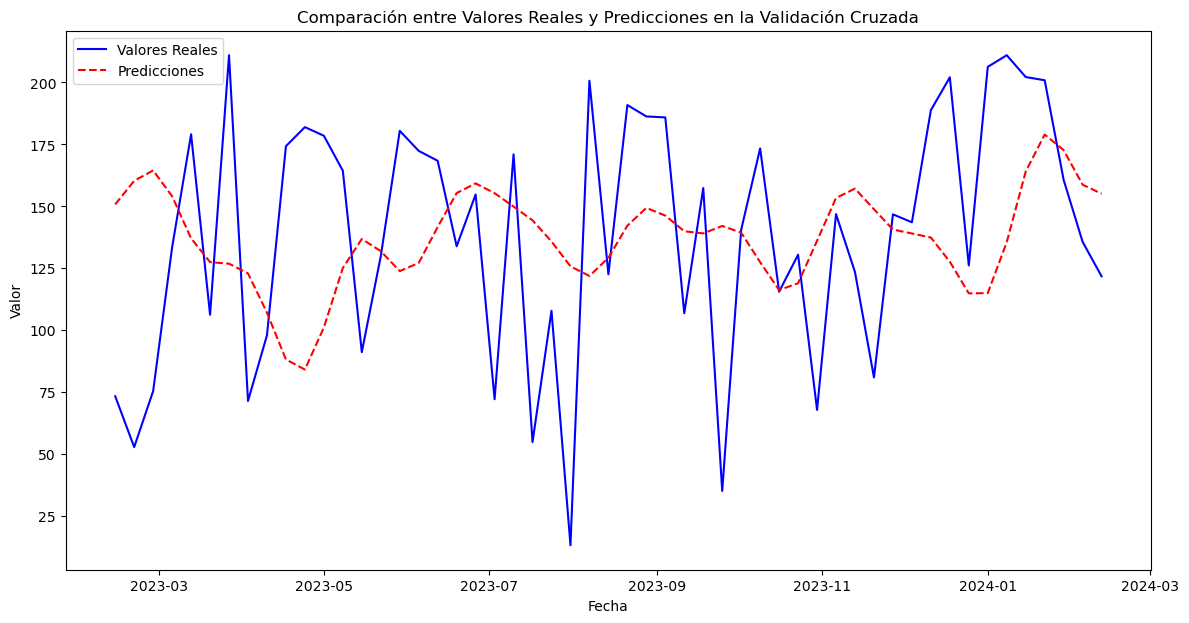

In [14]:
plt.figure(figsize=(14, 7))

# Plot de valores reales
plt.plot(df_cv1['ds'], df_cv1['y'], label='Valores Reales', color='blue')

# Plot de predicciones
plt.plot(df_cv1['ds'], df_cv1['yhat'], label='Predicciones', color='red', linestyle='--')

# Añadir etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Comparación entre Valores Reales y Predicciones en la Validación Cruzada')
plt.legend()

# Mostrar el gráfico
plt.show()

In [15]:
from prophet.diagnostics import performance_metrics
df_p1 = performance_metrics(df_cv1)
df_p1.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,35 days,5529.275022,74.359095,67.290215,0.930659,1.054715,0.569755,0.4
1,42 days,4420.745410,66.488686,56.052461,0.759654,0.234477,0.467958,0.6
2,49 days,3527.575934,59.393400,51.389352,0.433228,0.234477,0.366005,0.6
3,56 days,2472.062003,49.719835,43.875423,0.341331,0.234477,0.323489,0.8
4,63 days,2403.966075,49.030257,41.584805,0.329132,0.234477,0.312668,0.8


In [16]:
rmse1 = df_p1['rmse'].mean()
print(f'RMSE: {rmse1}')

RMSE: 53.06642337647916


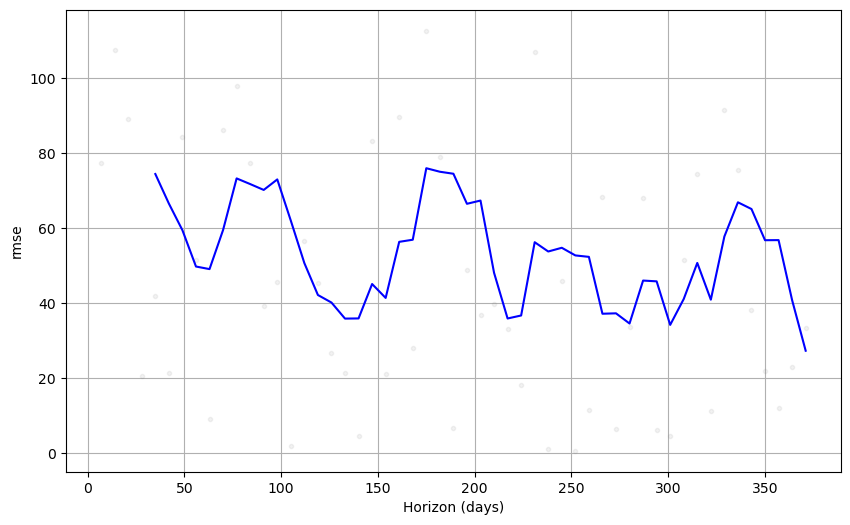

In [17]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv1, metric='rmse')

### Observados vs predicciones 

In [18]:
future = m1.predict(npivan)
future.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
263,2024-01-15,140.519920,108.576734,233.694202,140.519920,140.519920,31.081422,31.081422,31.081422,31.081422,31.081422,31.081422,0.0,0.0,0.0,171.601343
264,2024-01-22,140.627446,124.087327,241.949233,140.627446,140.627446,42.800545,42.800545,42.800545,42.800545,42.800545,42.800545,0.0,0.0,0.0,183.427991
265,2024-01-29,140.734971,114.984234,232.433428,140.734971,140.734971,33.137311,33.137311,33.137311,33.137311,33.137311,33.137311,0.0,0.0,0.0,173.872282
266,2024-02-05,140.842496,98.277940,214.517605,140.842496,140.842496,12.889697,12.889697,12.889697,12.889697,12.889697,12.889697,0.0,0.0,0.0,153.732193
267,2024-02-12,140.950022,83.817504,202.190753,140.950022,140.950022,0.146875,0.146875,0.146875,0.146875,0.146875,0.146875,0.0,0.0,0.0,141.096897


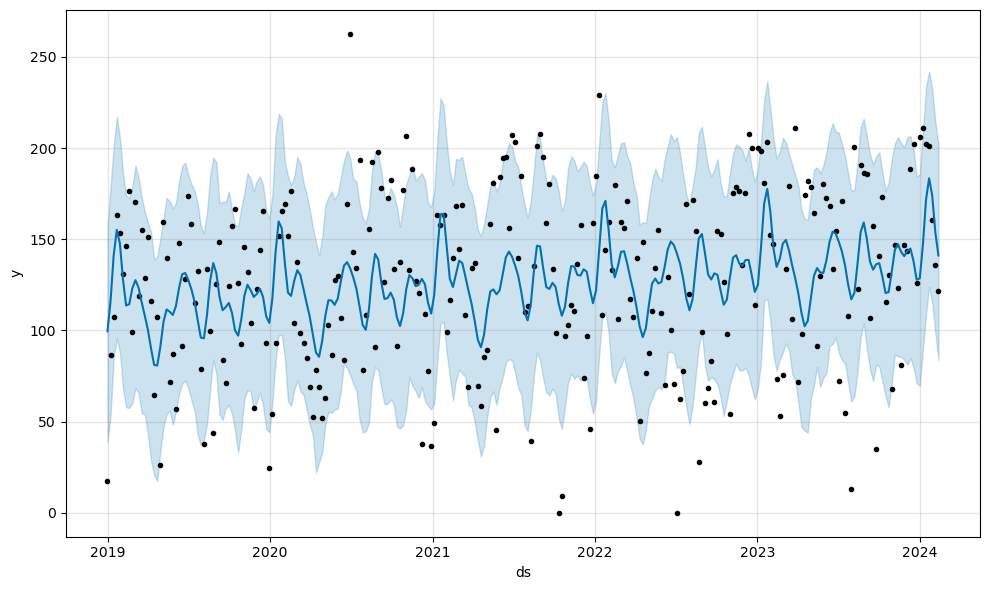

In [19]:
fig1 = m1.plot(future)

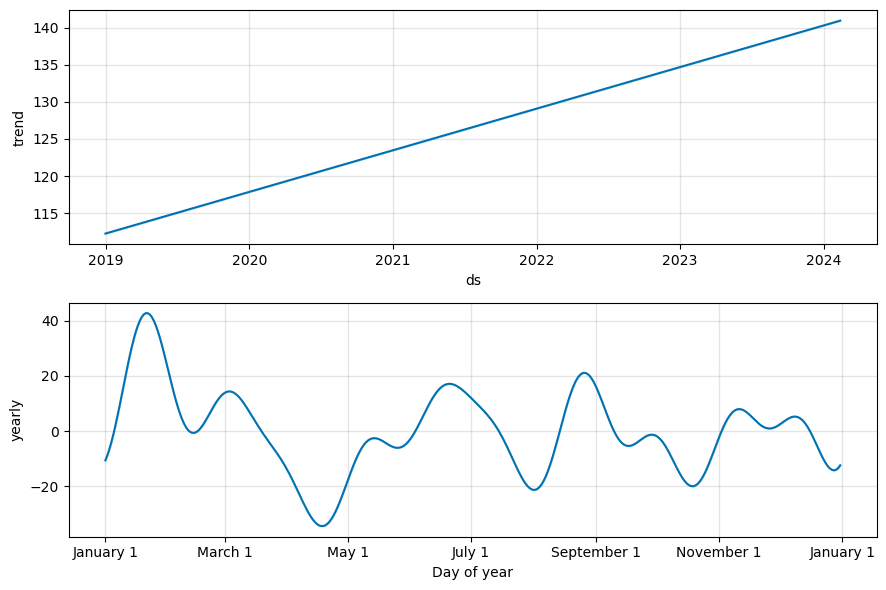

In [20]:
fig2 = m1.plot_components(future)

### Ajuste de la flexibilidad de la tendencia

Si los cambios de tendencia se están sobreajustando (demasiada flexibilidad) o subajustando (falta de flexibilidad), puede ajustar la fuerza de la distribución previa dispersa utilizando el argumento de entrada changepoint_prior_scale. De manera predeterminada, este parámetro está configurado en 0,05. Si lo aumenta, la tendencia será más flexible:

16:33:28 - cmdstanpy - INFO - Chain [1] start processing
16:33:28 - cmdstanpy - INFO - Chain [1] done processing


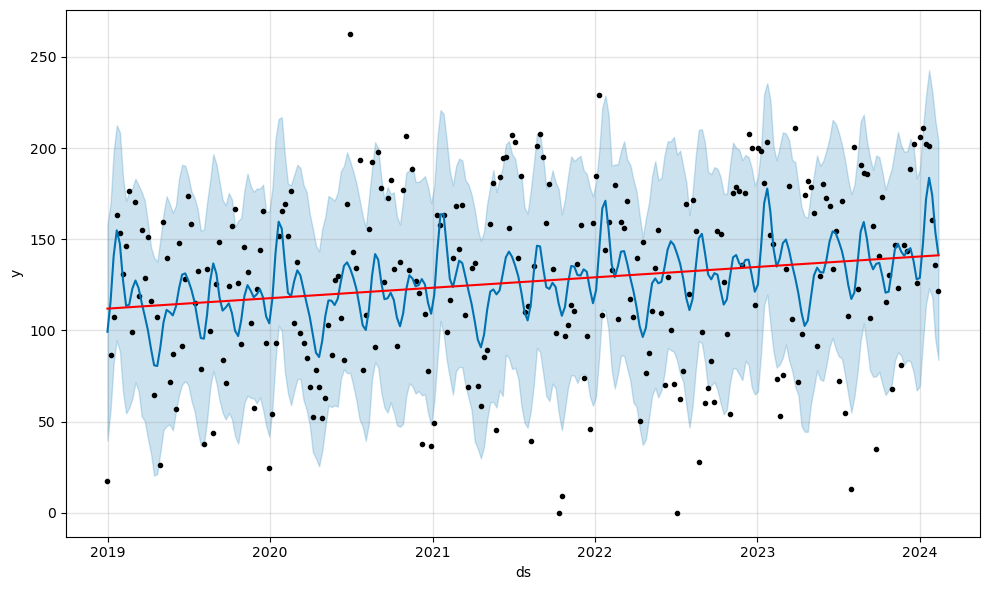

In [21]:
from prophet.plot import add_changepoints_to_plot
m2 = Prophet(changepoint_prior_scale=0.1)
forecast = m2.fit(npivan).predict(npivan)
fig = m2.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m2, forecast)

16:33:30 - cmdstanpy - INFO - Chain [1] start processing
16:33:30 - cmdstanpy - INFO - Chain [1] done processing


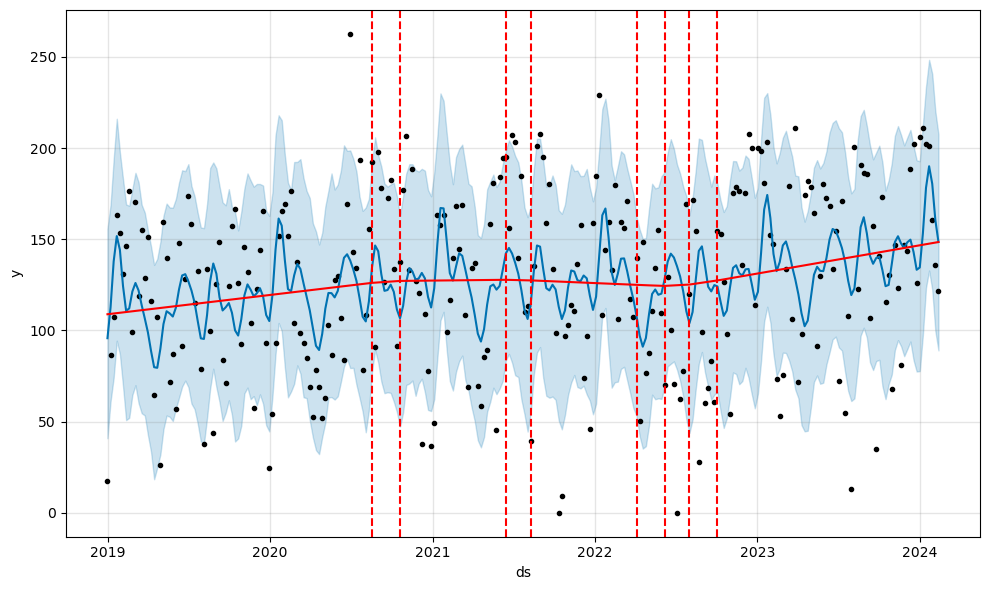

In [22]:
m3 = Prophet(changepoint_prior_scale=0.5)
forecast = m3.fit(npivan).predict(npivan)
fig = m3.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m3, forecast)

 En lugar de utilizar la detección automática de puntos de cambio, se pueden especificar manualmente las ubicaciones de los puntos de cambio potenciales con el argumento **changepoints**. Los cambios de pendiente se permitirán entonces solo en estos puntos, con la misma regularización dispersa que antes. Por ejemplo, se podría crear una cuadrícula de puntos como se hace automáticamente, pero luego aumentar esa cuadrícula con algunas fechas específicas que se sabe que es probable que tengan cambios. 

### Estacionalidad, efectos de las vacaciones y regresores

Si tiene días festivos u otros eventos recurrentes que desea modelar, debe crear un marco de datos para ellos. Tiene dos columnas ( holidayy ds) y una fila para cada ocurrencia del día festivo. Debe incluir todas las ocurrencias del día festivo, tanto en el pasado (hasta donde se remontan los datos históricos) como en el futuro (hasta donde se realiza el pronóstico). Si no se repetirán en el futuro, Prophet los modelará y luego no los incluirá en el pronóstico.

16:33:38 - cmdstanpy - INFO - Chain [1] start processing
16:33:38 - cmdstanpy - INFO - Chain [1] done processing


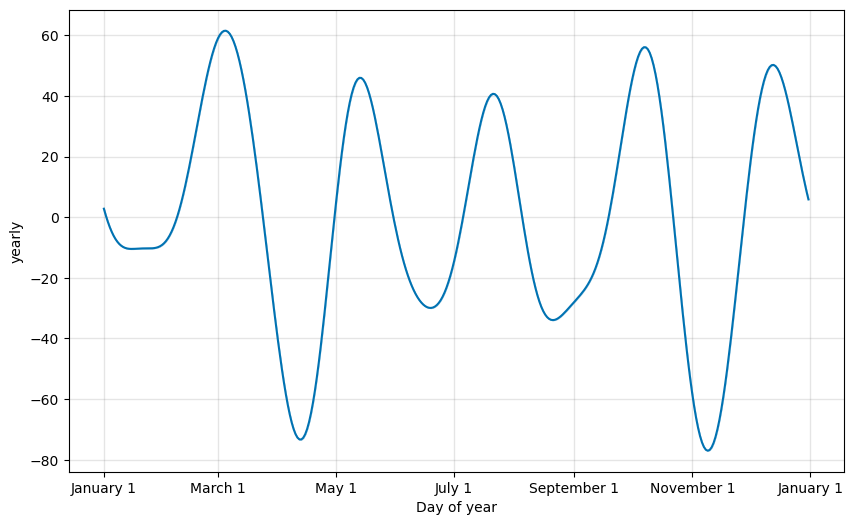

In [23]:
from prophet.plot import plot_yearly
m4=Prophet(changepoint_prior_scale=0.7,yearly_seasonality=True,n_changepoints=10,seasonality_mode="additive")
m4.add_country_holidays(country_name="CO")
m4.add_seasonality('quarterly', period=16.875, fourier_order=8)
m4.fit(npivan)
a = plot_yearly(m4)

### Incertidumbre en la tendencia

La mayor fuente de incertidumbre en el pronóstico es el potencial de cambios de tendencia futuros.Prophet es capaz de detectarlos y ajustarlos, Proyectamos estos cambios de tendencia hacia adelante y, al calcular su distribución, obtenemos intervalos de incertidumbre.Una propiedad de esta forma de medir la incertidumbre es que permitir una mayor flexibilidad en la tasa, al aumentar changepoint_prior_scale, aumentará la incertidumbre del pronóstico..El ancho de los intervalos de incertidumbre (por defecto 80%) se puede configurar mediante el parámetro **interval_width**. 

<Axes: xlabel='ds', ylabel='y'>

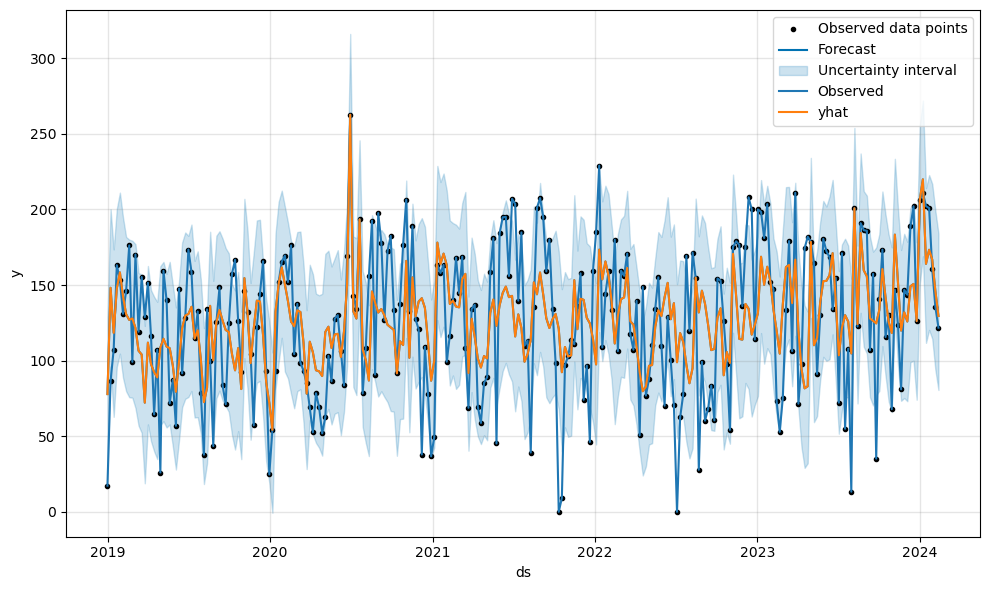

In [24]:
forecast =m4.predict(npivan)
m4.plot(forecast)
sns.lineplot(data=npivan, x="ds", y="y", label="Observed")
sns.lineplot(data=forecast, x="ds", y="yhat", label="yhat")

### Incertidumbre en la estacionalidad

De manera predeterminada, Prophet solo devolverá incertidumbre en la tendencia y ruido de observación. Para obtener incertidumbre en la estacionalidad, debe realizar un muestreo bayesiano completo. Esto se hace utilizando el parámetro mcmc.samples(que tiene un valor predeterminado de 0). 

In [25]:
m5=Prophet(changepoint_prior_scale=0.7,yearly_seasonality=True,n_changepoints=10,seasonality_mode="additive",interval_width=0.95,mcmc_samples=300)
m5.add_country_holidays(country_name="CO")
m5.add_seasonality('quarterly', period=16.875, fourier_order=21)
m5.add_regressor('time')
m5.fit(npivan, show_progress=False)

16:33:55 - cmdstanpy - INFO - CmdStan start processing
16:33:55 - cmdstanpy - INFO - Chain [1] start processing
16:33:55 - cmdstanpy - INFO - Chain [2] start processing
16:33:55 - cmdstanpy - INFO - Chain [3] start processing
16:33:55 - cmdstanpy - INFO - Chain [4] start processing
16:34:05 - cmdstanpy - INFO - Chain [4] done processing
16:34:05 - cmdstanpy - INFO - Chain [1] done processing
16:34:05 - cmdstanpy - INFO - Chain [2] done processing
16:34:05 - cmdstanpy - INFO - Chain [3] done processing
16:34:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exce

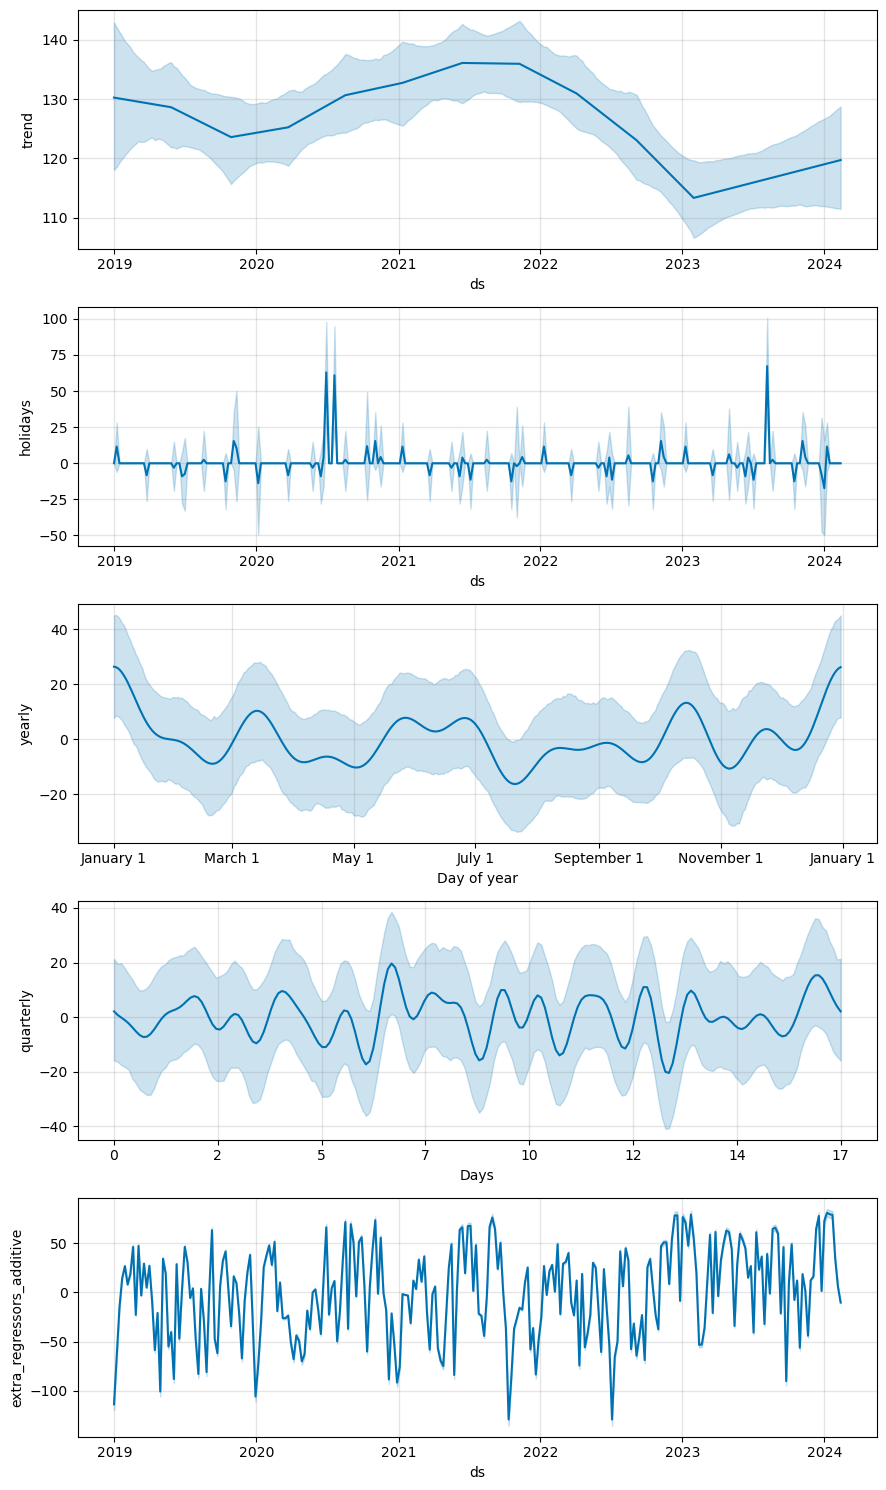

In [26]:
forecast=m5.predict(npivan)
fig = m5.plot_components(forecast)

 Prophet no tiene problemas con los datos faltantes. Si establece sus valores en NA en el historial pero deja las fechas en future, Prophet le dará una predicción de sus valores.

### Diagnóstico

#### Validación cruzada

Prophet incluye una funcionalidad para la validación cruzada de series temporales para medir el error de pronóstico utilizando datos históricos. Esto se hace seleccionando puntos de corte en el historial y, para cada uno de ellos, ajustando el modelo utilizando solo datos hasta ese punto de corte. Luego, podemos comparar los valores pronosticados con los valores reales.

Este procedimiento de validación cruzada se puede realizar automáticamente para un rango de fechas de corte históricas utilizando la cross_validationfunción. Especificamos el horizonte de pronóstico ( horizon), y luego, opcionalmente, el tamaño del período de entrenamiento inicial ( initial) y el espaciamiento entre las fechas de corte ( period). De manera predeterminada, el período de entrenamiento inicial se establece en tres veces el horizonte y se realizan cortes cada medio horizonte.

La validación cruzada también se puede ejecutar en modo paralelo en Python, especificando la parallelpalabra clave. Se admiten cuatro modos:

- parallel=None(Por defecto, sin paralelización)
- parallel="processes" (se recomienda este para procesos que no sean demasiado grandes)
- parallel="threads"
- parallel="dask"

### Ajuste de hiperparámetros

In [28]:
import itertools
import numpy as np
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# Define el espacio de búsqueda de hiperparámetros
param_grid = {  
    'changepoint_prior_scale': [0.5,0.6,0.7],
    'seasonality_prior_scale': [0.01, 0.1,0.5],
    'seasonality_mode':[ 'additive', 'multiplicative']
}

#También se pueden ajustar por medio de validación cruzada:
#    'holidays_prior_scale':[0.1, 1.0,2,3,4,5,6,7,8]
#    'changepoint_range':[0.7,0.8,0.9]

# Genera todas las combinaciones de parámetros
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Almacena los RMSEs para cada conjunto de parámetros aquí


# Definir los puntos de corte para la validación cruzada
cutoffs = pd.date_range(start=npivan['ds'].min(), end=npivan['ds'].max(), freq='52W')[1:-1]  # Excluye los extremos

# Evaluar todos los parámetros usando validación cruzada
for params in all_params:
    m6 = Prophet(**params) 
    m6.add_country_holidays(country_name="CO")
    m6.add_seasonality('quarterly', period=16.875, fourier_order=21)
    m6.add_regressor('time')# Crear el modelo con los parámetros actuales
    m6.fit(npivan)  # Entrenar el modelo

    # Realizar la validación cruzada
    df_cv = cross_validation(m6, 
                             cutoffs=cutoffs,
                             initial='214 W',  # 187 semanas
                             period='52 W',    # Frecuencia de validación cada 52 semanas
                             horizon='53 W',    # Horizonte de predicción de 12 semanas
                             parallel="processes")
    
    # Obtener métricas de rendimiento
    df_p = performance_metrics(df_cv, rolling_window=1)
    
    # Almacenar el RMSE
    rmses.append(df_p['rmse'].values[0])

# Encontrar los mejores parámetros
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

# Mostrar los resultados
print(tuning_results)

09:45:44 - cmdstanpy - INFO - Chain [1] start processing
09:45:45 - cmdstanpy - INFO - Chain [1] done processing
09:48:24 - cmdstanpy - INFO - Chain [1] start processing
09:48:24 - cmdstanpy - INFO - Chain [1] done processing
09:50:41 - cmdstanpy - INFO - Chain [1] start processing
09:50:42 - cmdstanpy - INFO - Chain [1] done processing
09:53:03 - cmdstanpy - INFO - Chain [1] start processing
09:53:03 - cmdstanpy - INFO - Chain [1] done processing
09:56:13 - cmdstanpy - INFO - Chain [1] start processing
09:56:14 - cmdstanpy - INFO - Chain [1] done processing
09:57:34 - cmdstanpy - INFO - Chain [1] start processing
09:57:35 - cmdstanpy - INFO - Chain [1] done processing
09:58:41 - cmdstanpy - INFO - Chain [1] start processing
09:58:41 - cmdstanpy - INFO - Chain [1] done processing
09:59:46 - cmdstanpy - INFO - Chain [1] start processing
09:59:46 - cmdstanpy - INFO - Chain [1] done processing
10:00:55 - cmdstanpy - INFO - Chain [1] start processing
10:00:55 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                       0.5                     0.01         additive   
1                       0.5                     0.01   multiplicative   
2                       0.5                     0.10         additive   
3                       0.5                     0.10   multiplicative   
4                       0.5                     0.50         additive   
5                       0.5                     0.50   multiplicative   
6                       0.6                     0.01         additive   
7                       0.6                     0.01   multiplicative   
8                       0.6                     0.10         additive   
9                       0.6                     0.10   multiplicative   
10                      0.6                     0.50         additive   
11                      0.6                     0.50   multiplicative   
12                      0.7                     0.0

In [29]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive'}


In [144]:
m7=Prophet(changepoint_prior_scale=0.7,seasonality_prior_scale=0.01,yearly_seasonality=20,seasonality_mode="additive")
m7.add_country_holidays(country_name="CO")
m7.add_seasonality('quarterly', period=16.875, fourier_order=21)
m7.add_regressor('time')
m7.fit(npivan)

17:24:54 - cmdstanpy - INFO - Chain [1] start processing
17:24:54 - cmdstanpy - INFO - Chain [1] done processing


In [145]:
from prophet.diagnostics import cross_validation
df_cv7 = cross_validation(
    m7, 
    initial='214 W',  # 187 semanas
    period='52 W',    # Frecuencia de validación cada 52 semanas
    horizon='53 W'    # Horizonte de predicción de 12 semanas
)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]17:24:55 - cmdstanpy - INFO - Chain [1] start processing
17:24:55 - cmdstanpy - INFO - Chain [1] done processing
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


In [146]:
df_cv7

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2023-02-13,63.108108,50.719403,76.361810,73.4,2023-02-06
1,2023-02-20,53.632515,40.735312,67.608835,52.9,2023-02-06
2,2023-02-27,70.884579,58.070196,84.299871,75.5,2023-02-06
3,2023-03-06,113.080753,100.611337,126.003925,133.5,2023-02-06
4,2023-03-13,161.179471,148.751782,173.595023,179.1,2023-02-06
5,2023-03-20,84.225022,71.364886,96.513802,106.3,2023-02-06
6,2023-03-27,162.979997,149.893874,176.086431,211.0,2023-02-06
7,2023-04-03,96.047997,83.334236,108.970353,71.5,2023-02-06
8,2023-04-10,137.008984,123.789887,149.478632,98.0,2023-02-06
9,2023-04-17,155.221045,143.563663,166.957597,174.3,2023-02-06


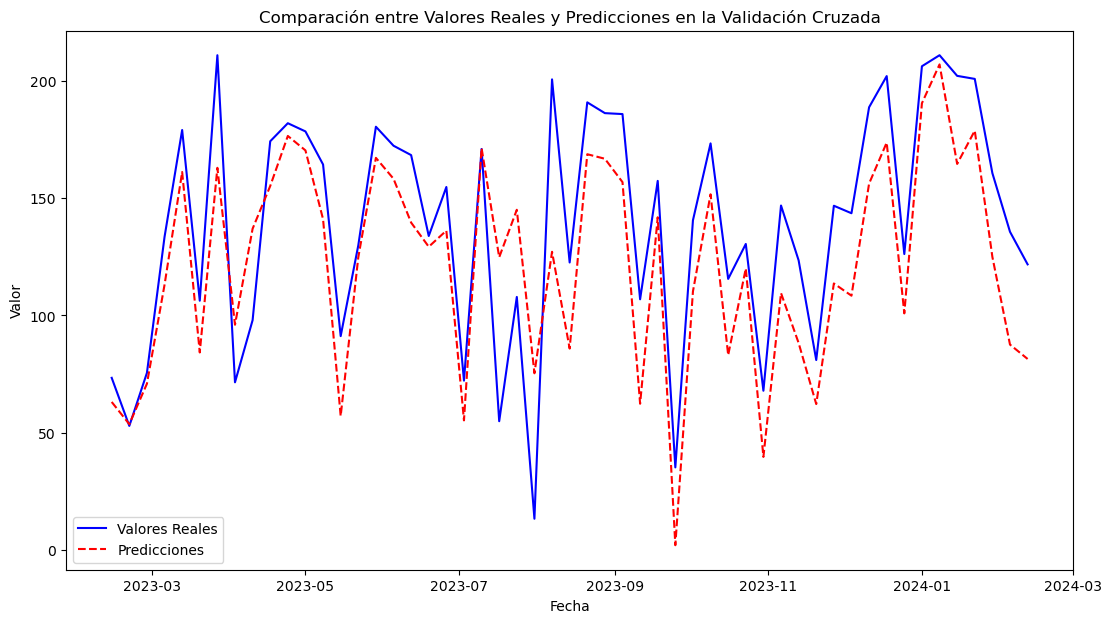

In [147]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 7))

# Plot de valores reales
plt.plot(df_cv7['ds'], df_cv7['y'], label='Valores Reales', color='blue')

# Plot de predicciones
plt.plot(df_cv7['ds'], df_cv7['yhat'], label='Predicciones', color='red', linestyle='--')

# Añadir etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Comparación entre Valores Reales y Predicciones en la Validación Cruzada')
plt.legend()

# Mostrar el gráfico
plt.show()

<Axes: xlabel='ds', ylabel='y'>

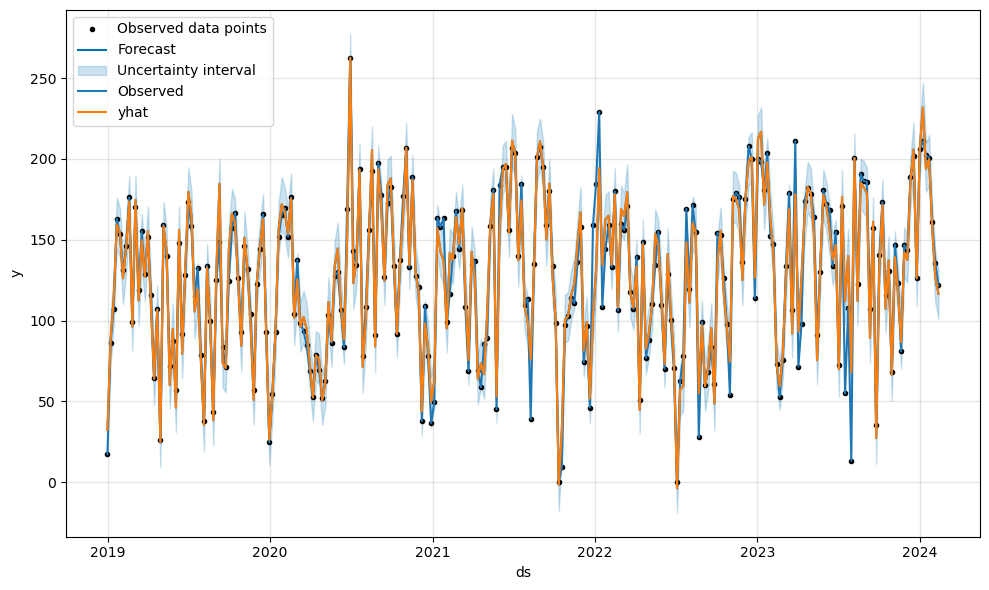

In [154]:
forecast =m7.predict(npivan)
m7.plot(forecast)
sns.lineplot(data=npivan, x="ds", y="y", label="Observed")
sns.lineplot(data=forecast, x="ds", y="yhat", label="yhat")

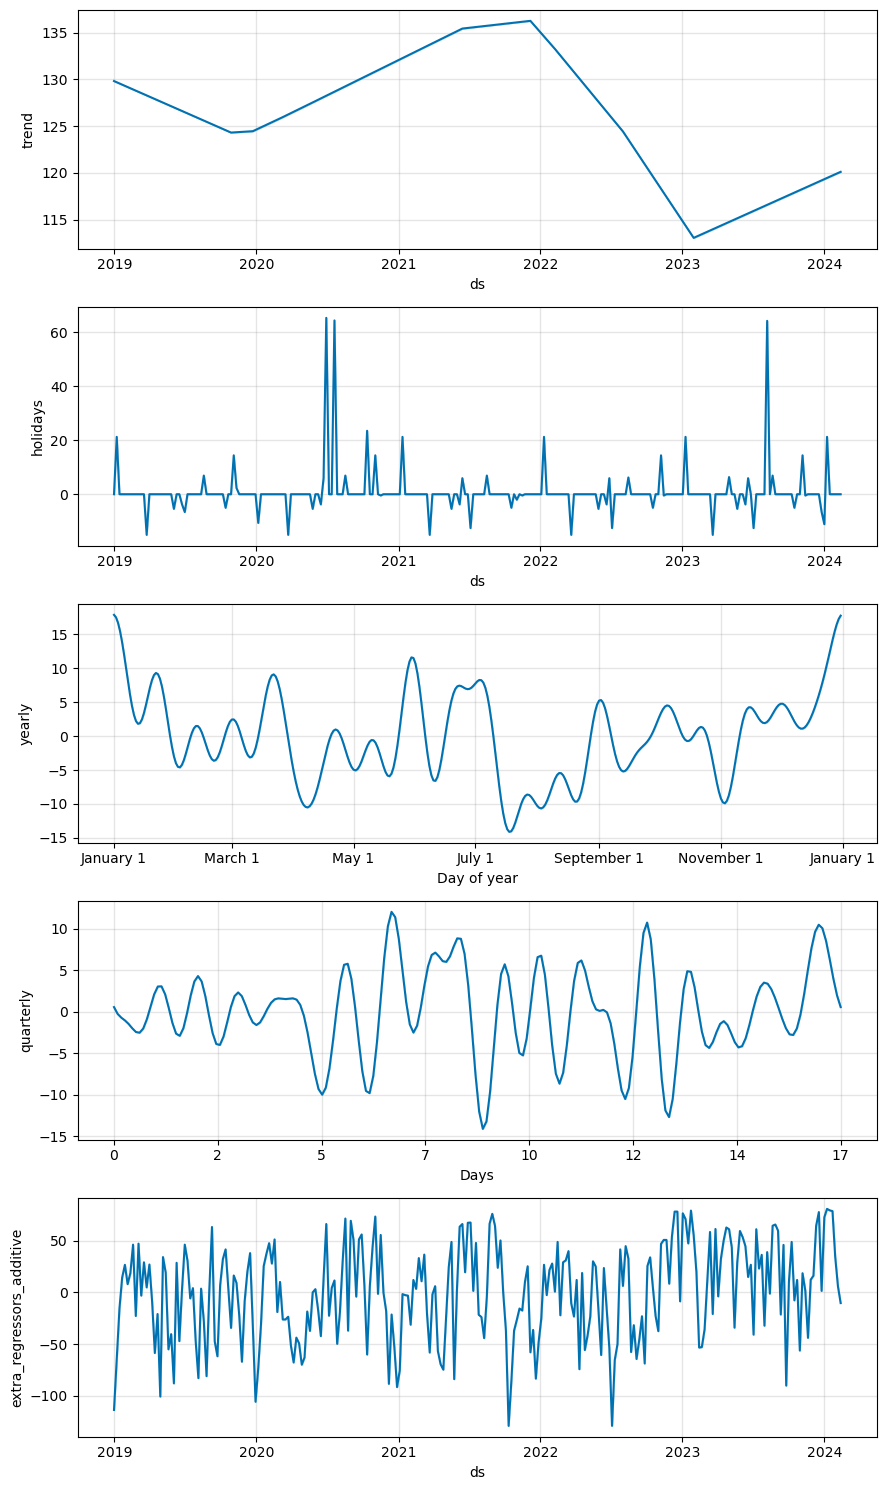

In [150]:
fig = m7.plot_components(forecast)

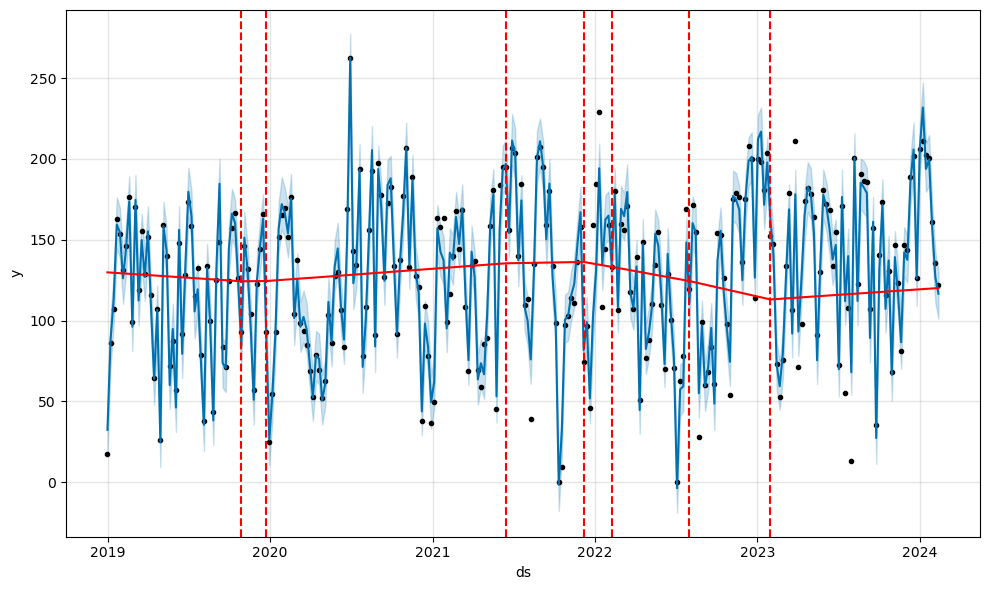

In [155]:
fig = m7.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m7, forecast)

**Errores**

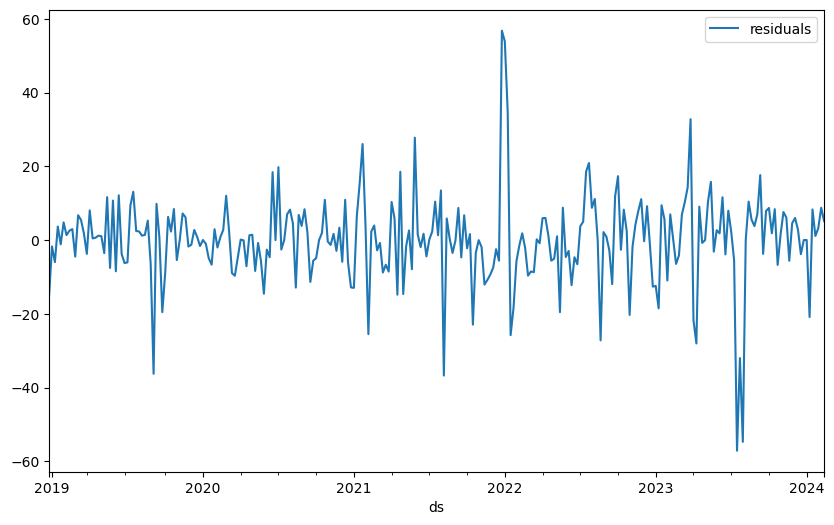

In [156]:
# Errores
df_residuals = pd.DataFrame({"ds": npivan["ds"], "residuals": npivan["y"] - forecast["yhat"]})
fig = df_residuals.plot(x="ds", y="residuals", figsize=(10, 6))

In [157]:
from prophet.diagnostics import performance_metrics
df_p7 = performance_metrics(df_cv7)
df_p7.head()
rmse7 = df_p7['rmse'].mean()
print(f'RMSE: {rmse7}')

RMSE: 29.369699770349158


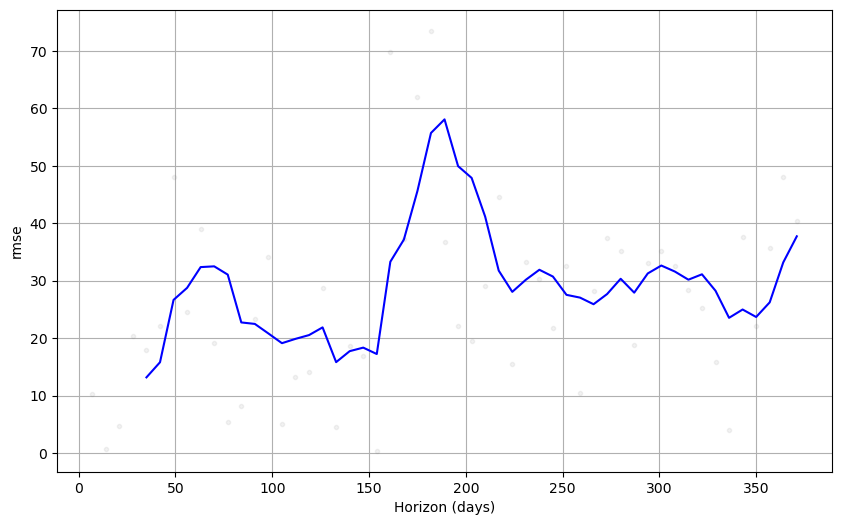

In [158]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv7, metric='rmse')

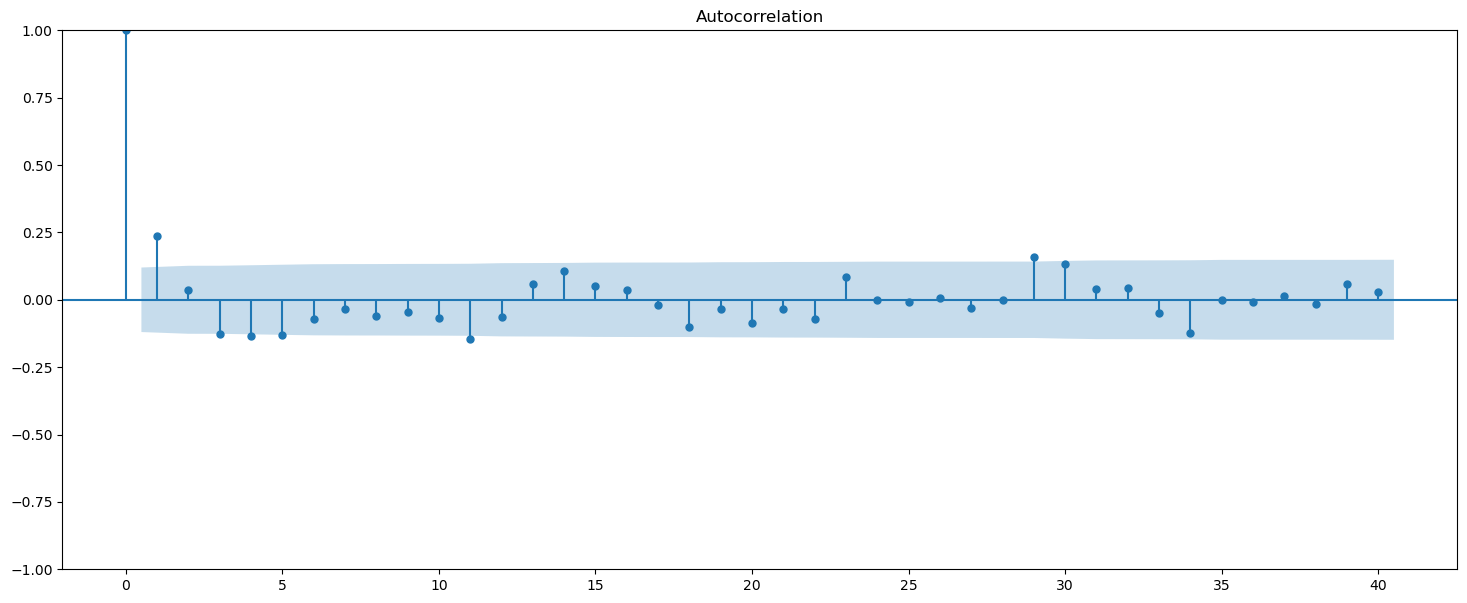

In [153]:
from statsmodels.graphics.tsaplots import plot_acf

plt = plot_acf(df_residuals["residuals"].dropna(), lags=40)

#### Hiperámetros que se pueden ajustar

- changepoint_prior_scale:Este es probablemente el parámetro más impactante. Determina la flexibilidad de la tendencia y, en particular, cuánto cambia la tendencia en los puntos de cambio de tendencia..El valor predeterminado de 0,05 funciona para muchas series temporales, pero se podría ajustar; un rango de [0,001, 0,5] probablemente sería adecuado. Los parámetros como este (penalizaciones por regularización; esto es efectivamente una penalización de lazo) a menudo se ajustan en una escala logarítmica.
- seasonality_prior_scale: Este parámetro controla la flexibilidad de la estacionalidad. De manera similar, un valor grande permite que la estacionalidad se ajuste a grandes fluctuaciones, un valor pequeño reduce la magnitud de la estacionalidad. El valor predeterminado es 10, que básicamente no aplica ninguna regularización. Esto se debe a que rara vez vemos sobreajustes aquí (hay una regularización inherente con el hecho de que se está modelando con una serie de Fourier truncada, por lo que esencialmente se filtra con paso bajo). Un rango razonable para ajustarlo probablemente sería [0.01, 10]
- holidays_prior_scale:Esto controla la flexibilidad para ajustar los efectos de las vacaciones. De manera similar a seasonality_prior_scale, el valor predeterminado es 10.0, que básicamente no aplica ninguna regularización, ya que normalmente tenemos múltiples observaciones de las vacaciones y podemos hacer un buen trabajo de estimación de sus efectos. Esto también se puede ajustar en un rango de [0.01, 10] como con seasonality_prior_scale.
- seasonality_mode: Las opciones son [ 'additive', 'multiplicative']. El valor predeterminado es 'additive', pero muchas series temporales comerciales tendrán estacionalidad multiplicativa. Esto se identifica mejor simplemente observando la serie temporal y viendo si la magnitud de las fluctuaciones estacionales crece con la magnitud de la serie temporal.
- changepoint_range:Esta es la proporción del historial en la que se permite que cambie la tendencia. El valor predeterminado es 0,8, el 80 % del historial, lo que significa que el modelo no ajustará ningún cambio de tendencia en el último 20 % de la serie temporal. Esto es bastante conservador, para evitar un sobreajuste a los cambios de tendencia al final de la serie temporal, donde no queda suficiente margen para ajustarlo bien

#### Parámetros que probablemente no se ajustarán


- growth:Las opciones son "lineal" y "logística". Es probable que no se ajusten; si hay un punto de saturación conocido y un crecimiento hacia ese punto, se incluirá y se utilizará la tendencia logística; de lo contrario, será lineal.
- changepoints: Esto sirve para especificar manualmente las ubicaciones de los puntos de cambio. Ninguno de manera predeterminada, lo que los coloca automáticamente.
- n_changepoints: Esta es la cantidad de puntos de cambio colocados automáticamente. El valor predeterminado de 25 debería ser suficiente para capturar los cambios de tendencia en una serie temporal típica (al menos el tipo en el que Prophet funcionaría bien de todos modos). En lugar de aumentar o disminuir la cantidad de puntos de cambio, probablemente sea más eficaz concentrarse en aumentar o disminuir la flexibilidad en esos cambios de tendencia, lo que se hace con changepoint_prior_scale.
- yearly_seasonality:De manera predeterminada ('auto'), esto activará la estacionalidad anual si hay un año de datos y la desactivará en caso contrario. Las opciones son ['auto', True, False]. Si hay más de un año de datos, en lugar de intentar desactivar esto durante HPO, probablemente sea más efectivo dejarlo activado y desactivar los efectos estacionales mediante el ajuste seasonality_prior_scale.
- weekly_seasonality:Lo mismo que para yearly_seasonality.
- daily_seasonality:Lo mismo que para yearly_seasonality.
- holidays:Esto sirve para pasar un marco de datos de días festivos específicos. Los efectos de los días festivos se ajustarían con holidays_prior_scale.
- mcmc_samplesEl uso o no del MCMC probablemente dependerá de factores como la longitud de la serie temporal y la importancia de la incertidumbre de los parámetros (estas consideraciones se describen en la documentación).
- interval_width: Prophet predictdevuelve intervalos de incertidumbre para cada componente, como yhat_lowery yhat_upperpara el pronóstico yhat. Estos se calculan como cuantiles de la distribución predictiva posterior y interval_widthespecifica qué cuantiles utilizar. El valor predeterminado de 0,8 proporciona un intervalo de predicción del 80 %. Puede cambiarlo a 0,95 si desea un intervalo del 95 %. Esto afectará solo el intervalo de incertidumbre y no cambiará el pronóstico yhaten absoluto, por lo que no es necesario ajustarlo.
- uncertainty_samples:Los intervalos de incertidumbre se calculan como cuantiles a partir del intervalo predictivo posterior, y el intervalo predictivo posterior se estima con muestreo de Monte Carlo. Este parámetro es el número de muestras a utilizar (el valor predeterminado es 1000). El tiempo de ejecución de predict será lineal en este número. Si lo hace más pequeño, aumentará la varianza (error de Monte Carlo) del intervalo de incertidumbre, y si lo hace más grande, reducirá esa varianza. Por lo tanto, si las estimaciones de incertidumbre parecen irregulares, se podría aumentar esto para suavizarlas aún más, pero probablemente no sea necesario cambiarlo. Al igual que con interval_width, este parámetro solo afecta los intervalos de incertidumbre y cambiarlo no afectará de ninguna manera el pronóstico yhat; no necesita ajustarse.